# Project Proposal


## Title: Grand Slam Off the Court

Group Number: 20

Group Members: Manushree Singhania, Bryan Chang, Shubham Sharma, Yoson Hsu

Data Set: Player Stats for Top 500 Players


In [1]:
library(tidyverse)
library(repr)
library(digest)
library(GGally)
library(ISLR)
library(lubridate)
library(tidymodels)
library(dplyr)
options(repr.matrix.max.rows = 6)

set.seed(1234)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2


Attaching package: ‘lubridate’


The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union


Warning message:
“package ‘tidymodels’ was built under R version 4.0.2”
── Attaching packages ────────────────────────────────────── ti

## Introduction

## Preliminary exploratory data analysis

In [2]:

#read the data through the given url
player_stats_raw <- read_csv("https://drive.google.com/uc?export=download&id=1_MECmUXZuuILYeEOfonSGqodW6qVdhsS")


#select the required columns of the data, convert the the characters into doubles and integers for best rank, prize money, age
# renamed the columns to give them meaningful names, filtered the rows where values were unavailable i.e. NA. Covereted the 
# coolumns for Backhand, Handedness as factors. Added a new column to demonstrate whether the carrer earnings of a player 
# is within the top 30 career earnings of the player all over the world.

player_stats_refined <- player_stats_raw %>%
                        select(Age, Plays, 'Best Rank', Name, Backhand, 'Prize Money', Height, Seasons) %>%
                        separate(col = 'Best Rank', into = c('Best Rank', 'Date of Best Rank'), sep = " ", convert = TRUE) %>%
                        rename(Best_Rank = 'Best Rank', Date_of_Best_Rank = 'Date of Best Rank', Prize_Money = 'Prize Money') %>%
                        select(-Date_of_Best_Rank) %>%
                        filter(Height != "NA") %>%
                        separate(col = Age, into = c('Age', 'DOB'), sep = " ", convert = TRUE) %>%
                        separate(col = Prize_Money, into = c('Prize_Money', 'PMO'), sep = " ", convert = TRUE) %>%
                        select(-DOB) %>%
                        rename(Handedness = 'Plays')


player_stats_refined$Prize<-gsub("[^0-9]","",player_stats_refined$Prize_Money)
player_stats_refined <- player_stats_refined %>%
                        select(-PMO,-Prize_Money)%>%
                        mutate(Prize=as.numeric(Prize))%>%
                        filter(Prize != "NA")%>%
                        arrange(by= desc(Prize))



thirty_prize_money <- player_stats_refined$Prize[30] 


player_stats_mutated <- player_stats_refined %>%
                        mutate(Backhand=as_factor(Backhand))%>%
                        mutate(Handedness=as_factor(Handedness))

player_stats_mutated$Height<-gsub("[^0-9]","",player_stats_mutated$Height)

player_stats_mutated <- player_stats_mutated %>%
                        mutate(Height=as.numeric(Height))%>%
                        rename(Seasons_active=Seasons, Career_earnings=Prize)

player_stats_mutated

Warning message:
“Missing column names filled in: 'X1' [1]”
Parsed with column specification:
cols(
  .default = col_character(),
  X1 = col_double(),
  `Turned Pro` = col_double(),
  Seasons = col_double(),
  Titles = col_double(),
  `Best Season` = col_double(),
  Retired = col_double(),
  Masters = col_double(),
  `Grand Slams` = col_double(),
  `Davis Cups` = col_double(),
  `Team Cups` = col_double(),
  Olympics = col_double(),
  `Weeks at No. 1` = col_double(),
  `Tour Finals` = col_double()
)

See spec(...) for full column specifications.

Warning message:
“Expected 2 pieces. Additional pieces discarded in 20 rows [3, 26, 32, 36, 48, 49, 61, 62, 73, 79, 80, 85, 91, 100, 104, 106, 107, 112, 113, 115].”
Warning message:
“Expected 2 pieces. Missing pieces filled with `NA` in 91 rows [1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 16, 18, 19, 20, 21, 22, 23, ...].”


Age,Handedness,Best_Rank,Name,Backhand,Height,Seasons_active,Career_earnings
<int>,<fct>,<int>,<chr>,<fct>,<dbl>,<dbl>,<dbl>
33,Left-handed,1,Rafael Nadal,Two-handed,185,19,119601561
31,Right-handed,3,Juan Martin Del Potro,Two-handed,198,14,25889586
26,Right-handed,4,Dominic Thiem,One-handed,185,10,22132368
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
28,Right-handed,183,Laurynas Grigelis,Two-handed,183,8,327684
28,Right-handed,286,Sandro Ehrat,Two-handed,180,3,95194
32,Right-handed,28,Santiago Giraldo,Two-handed,188,14,4416


In [3]:
# Dividing the data into training and testing set with 75% data in training set and 25% in testing set.

options(repr.plot.height = 5, repr.plot.width = 6)

player_split <- initial_split(player_stats_mutated, prop = 0.75, strata = Career_earnings)  
player_train <- training(player_split)   
player_test <- testing(player_split)

player_train
player_test

Age,Handedness,Best_Rank,Name,Backhand,Height,Seasons_active,Career_earnings
<int>,<fct>,<int>,<chr>,<fct>,<dbl>,<dbl>,<dbl>
33,Left-handed,1,Rafael Nadal,Two-handed,185,19,119601561
31,Right-handed,3,Juan Martin Del Potro,Two-handed,198,14,25889586
26,Right-handed,4,Dominic Thiem,One-handed,185,10,22132368
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
28,Right-handed,183,Laurynas Grigelis,Two-handed,183,8,327684
28,Right-handed,286,Sandro Ehrat,Two-handed,180,3,95194
32,Right-handed,28,Santiago Giraldo,Two-handed,188,14,4416


Age,Handedness,Best_Rank,Name,Backhand,Height,Seasons_active,Career_earnings
<int>,<fct>,<int>,<chr>,<fct>,<dbl>,<dbl>,<dbl>
22,Right-handed,3,Alexander Zverev,Two-handed,198,8,20028563
36,Left-handed,7,Fernando Verdasco,Two-handed,188,19,17353811
32,Right-handed,25,Jeremy Chardy,Two-handed,188,15,8658443
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
34,Right-handed,78,Konstantin Kravchuk,Two-handed,190,9,1031708
30,Right-handed,98,Andrej Martin,Two-handed,180,7,898701
31,Right-handed,112,Attila Balazs,Two-handed,180,8,450046


In [4]:
num_obs <- nrow(player_train)

#summarized the data in the training set by grouping them based on seasons, and summarized the rest of the columns by 
# calculating the mean of Career_earnings, Height, Best_Rank, Age and percentage of Handedness, Backhand, is_within_thirty
# for each season and arranged them by seasons.
player_summarized <- player_train %>%
                        group_by(Seasons_active)%>%
                            summarize(Handedness_percentage=n() / num_obs * 100,Backhand_percentage=n() / num_obs * 100,
                              Age=mean(Age),Best_Rank=mean(Best_Rank),
                                      Height=mean(Height))%>%
                            arrange(by=Seasons_active)

#Count the number of players for each type of handedness in the training data i.e. Left-handed and Right-Handed
player_Handedness <- player_train %>%
                        group_by(Handedness)%>%
                        summarize(
                                count = n(),
                        percentage = n() / num_obs * 100)

#Count the number of players for each type of Backhand in the training data i.e. Two-handed and One-handed
player_Backhand <- player_train %>%
                        group_by(Backhand)%>%
                        summarize(
                                count = n(),
                        percentage = n() / num_obs * 100)

#Count the number of players for each type of handedness i.e. Left-handed and Right-Handed
player_Handedness_true <- player_stats_mutated %>%
                        group_by(Handedness)%>%
                        summarize(
                                count = n(),
                        percentage = n() / 101 * 100)

#Count the number of players for each type of Backhand i.e. Two-handed and One-handed
player_Backhand_true <- player_stats_mutated %>%
                        group_by(Backhand)%>%
                        summarize(
                                count = n(),
                        percentage = n() / 101 * 100)

player_summarized
player_Handedness
player_Handedness_true
player_Backhand
player_Backhand_true

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)



Seasons_active,Handedness_percentage,Backhand_percentage,Age,Best_Rank,Height
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
3,2.597403,2.597403,27.50000,235.50000,182.5
5,2.597403,2.597403,27.50000,124.50000,183.0
7,3.896104,3.896104,27.66667,52.33333,186.0
⋮,⋮,⋮,⋮,⋮,⋮
19,1.298701,1.298701,33,1.0,185
20,2.597403,2.597403,39,25.5,199
21,1.298701,1.298701,37,5.0,180


Handedness,count,percentage
<fct>,<int>,<dbl>
Left-handed,10,12.98701
Right-handed,67,87.01299


Handedness,count,percentage
<fct>,<int>,<dbl>
Left-handed,14,13.86139
Right-handed,87,86.13861


Backhand,count,percentage
<fct>,<int>,<dbl>
Two-handed,61,79.22078
One-handed,16,20.77922


Backhand,count,percentage
<fct>,<int>,<dbl>
Two-handed,82,81.18812
One-handed,19,18.81188


## Methods

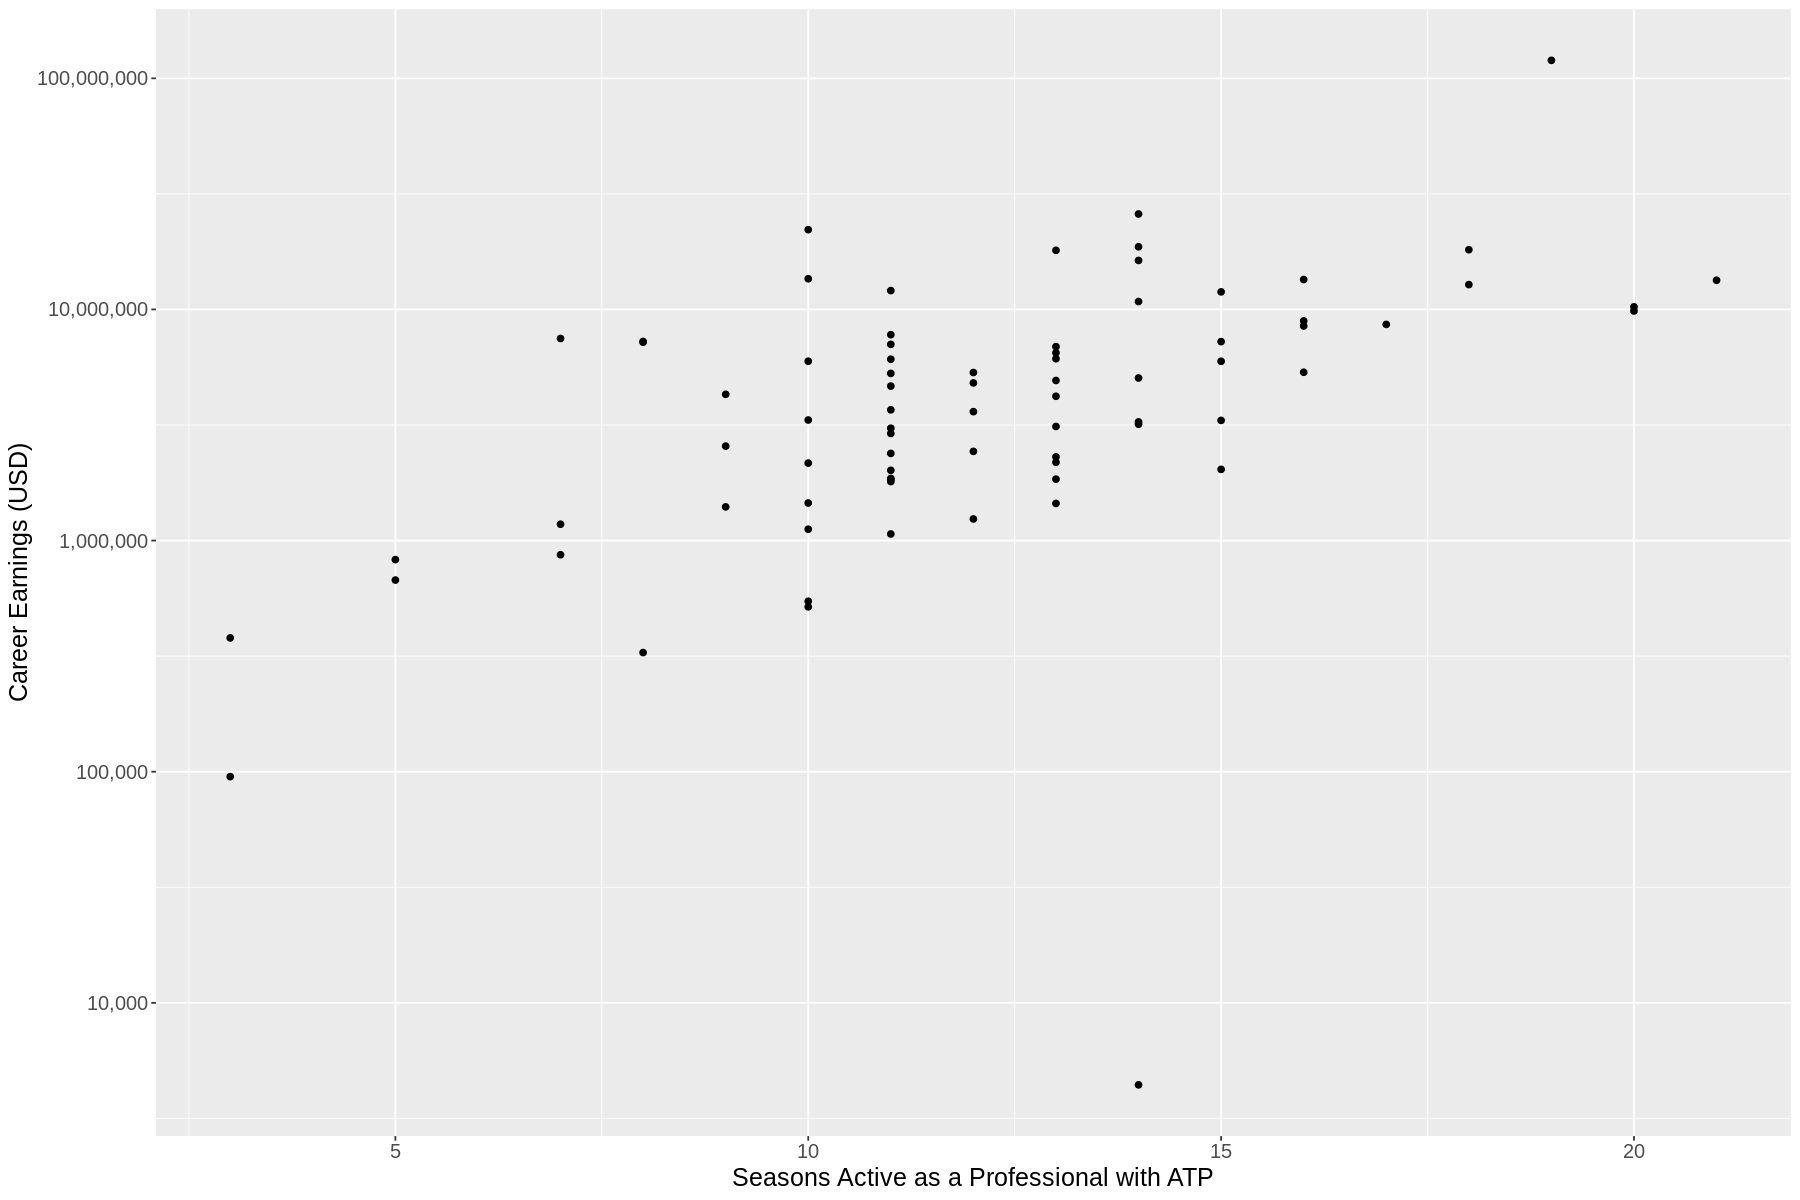

In [5]:
options(repr.plot.height = 10, repr.plot.width = 15)

seasons_v_pm <- ggplot(player_train, aes(x = Seasons_active, y = Career_earnings))+
      geom_point() +
      labs(x = "Seasons Active as a Professional with ATP", y = "Career Earnings (USD)") + 
        theme(text= element_text(size=15))+
        scale_y_log10(labels= label_comma())

seasons_v_pm

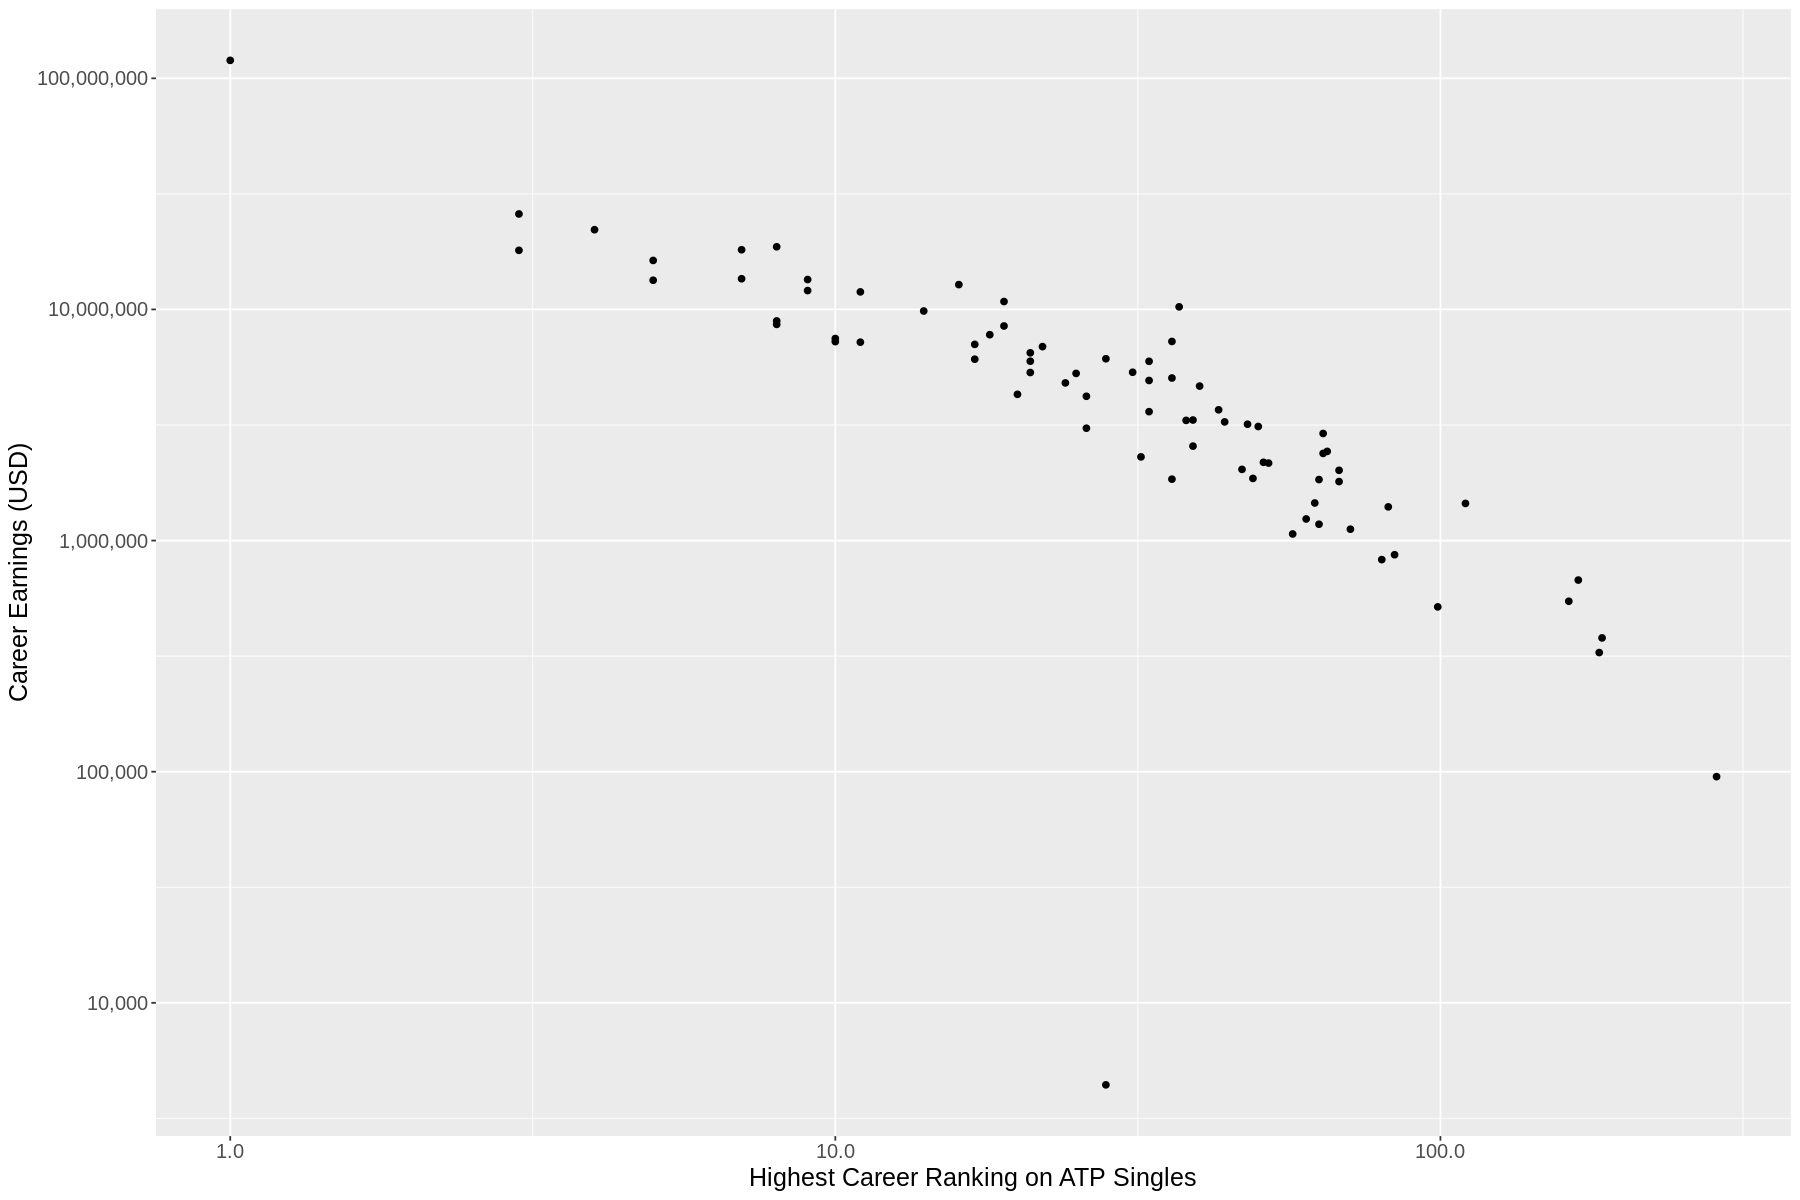

In [6]:
best_rank_vs_pm <- ggplot(player_train, aes(x = Best_Rank, y = Career_earnings))+
      geom_point() +
      labs(x = "Highest Career Ranking on ATP Singles", y = "Career Earnings (USD)") + 
        theme(text= element_text(size=15))+
        scale_y_log10(labels= label_comma())+
        scale_x_log10(labels= label_comma())

        
best_rank_vs_pm

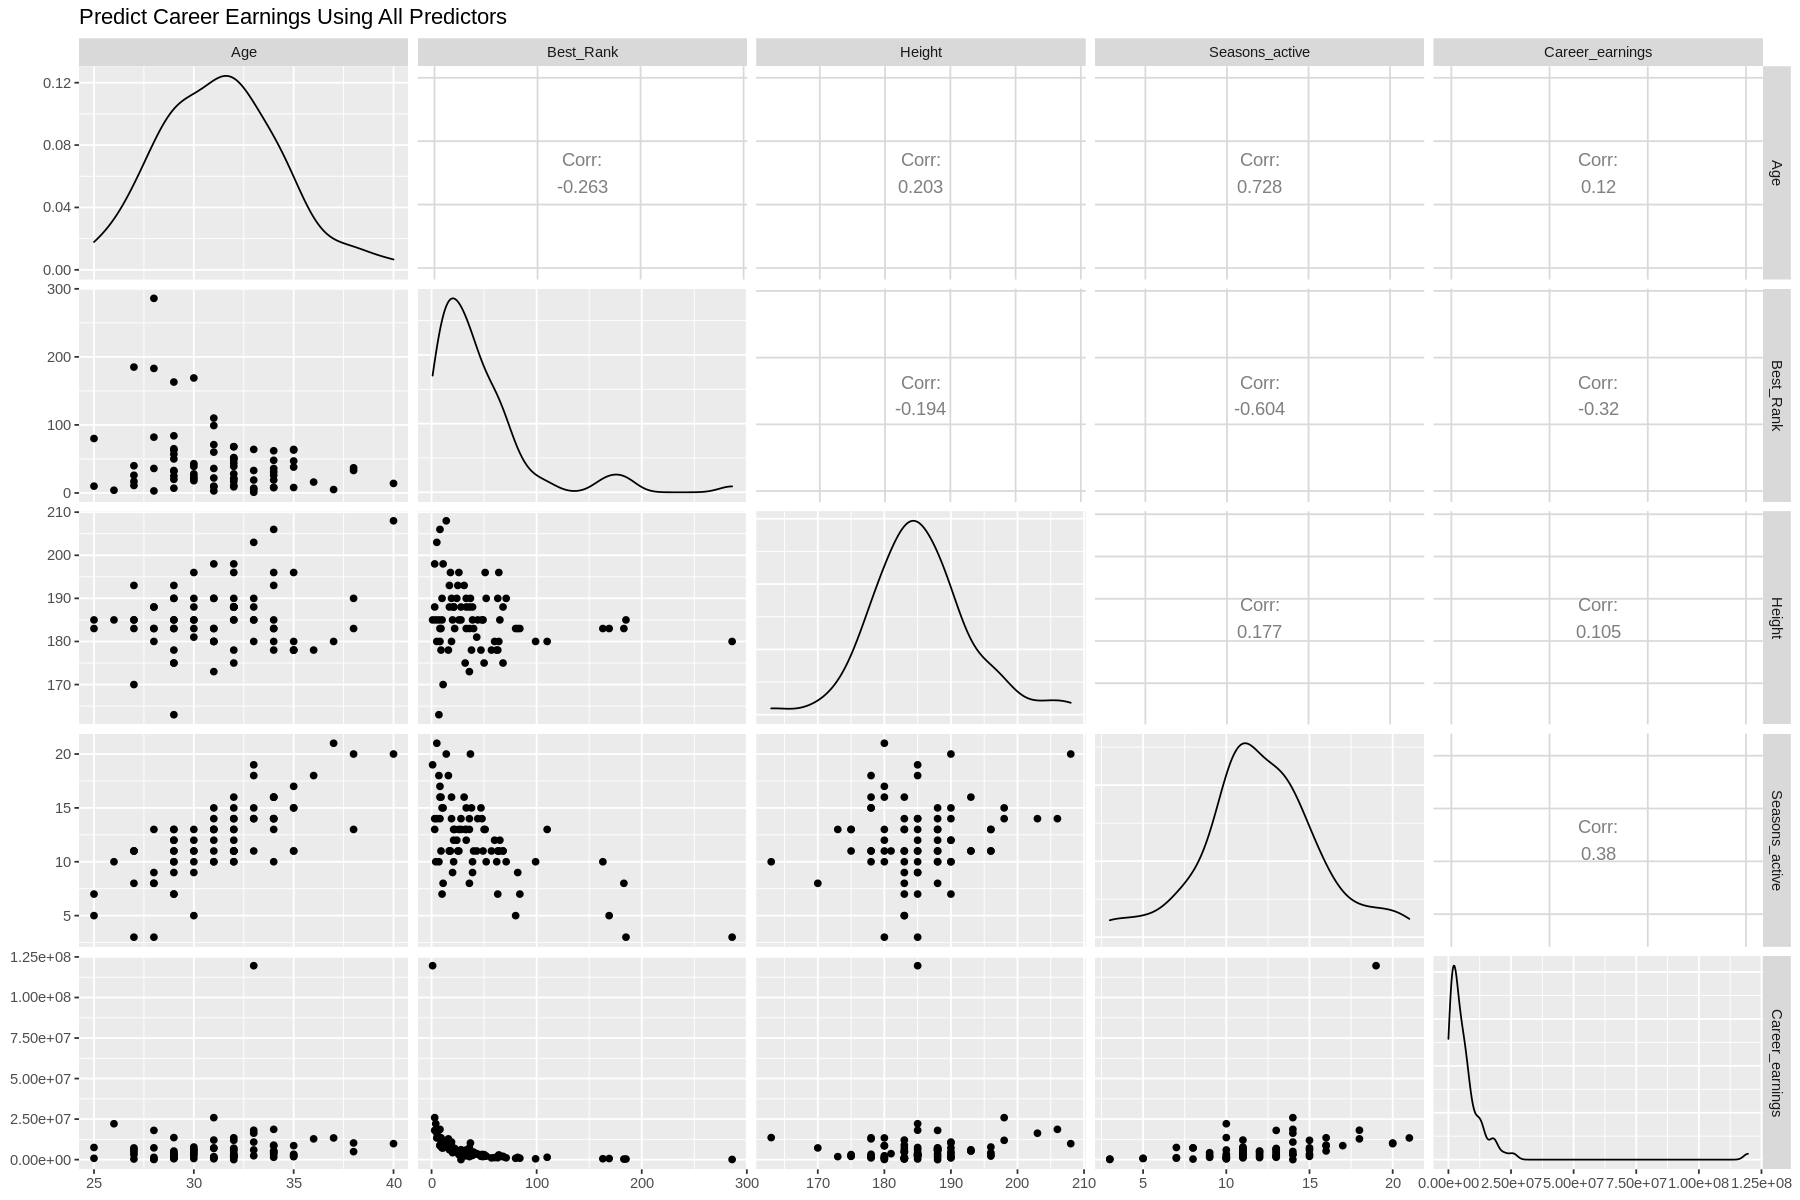

In [7]:
player_train_viz <- player_train %>%
                    select(-Handedness,-Name,-Backhand)

player_train_viz_plot <- ggpairs(player_train_viz, columns= 1:5,title="Predict Career Earnings Using All Predictors")
player_train_viz_plot

In [11]:
# Creating a model specification for knn regression model to find the most accurate number of neighbors


player_spec <- nearest_neighbor(weight_func = "rectangular", 
                              neighbors = tune())%>%
                          set_engine("kknn") %>%
                          set_mode("regression")

# creating the recipe for the knn regression on training set of the data frame player 
player_recipe <- recipe(Career_earnings ~ Height+ Age+ Best_Rank+ Seasons_active, data = player_train) %>%
  step_scale(all_predictors()) %>%
  step_center(all_predictors())

player_vfold <- vfold_cv(player_train, v = 5, strata = Career_earnings)


#crreating a workflow for knn regression to find the appropriate number of neighnors to perform regression
player_wkflw <- workflow() %>%
  add_recipe(player_recipe) %>%
  add_model(player_spec)

player_wkflw

Warning message:
“The number of observations in each quantile is below the recommended threshold of 20. Stratification will be done with 3 breaks instead.”


══ Workflow ════════════════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

● step_scale()
● step_center()

── Model ───────────────────────────────────────────────────────────────────────
K-Nearest Neighbor Model Specification (regression)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 


In [9]:
gridvals <- tibble(neighbors = seq(from = 1, to = 60, by = 2))

player_results <- player_wkflw %>%
  tune_grid(resamples = player_vfold, grid = gridvals) %>%
  collect_metrics() %>%
  filter(.metric == "rmse")

player_results

x Fold1: model 1/1: Error in best[1, 2]: subscript out of bounds



neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,rmse,standard,15378160,4,6498794,Model01
3,rmse,standard,12476535,4,5261219,Model02
5,rmse,standard,10608203,4,5986588,Model03
⋮,⋮,⋮,⋮,⋮,⋮,⋮
55,rmse,standard,10996822,4,6161707,Model28
57,rmse,standard,11141467,4,6122258,Model29
59,rmse,standard,11388593,4,6052002,Model30


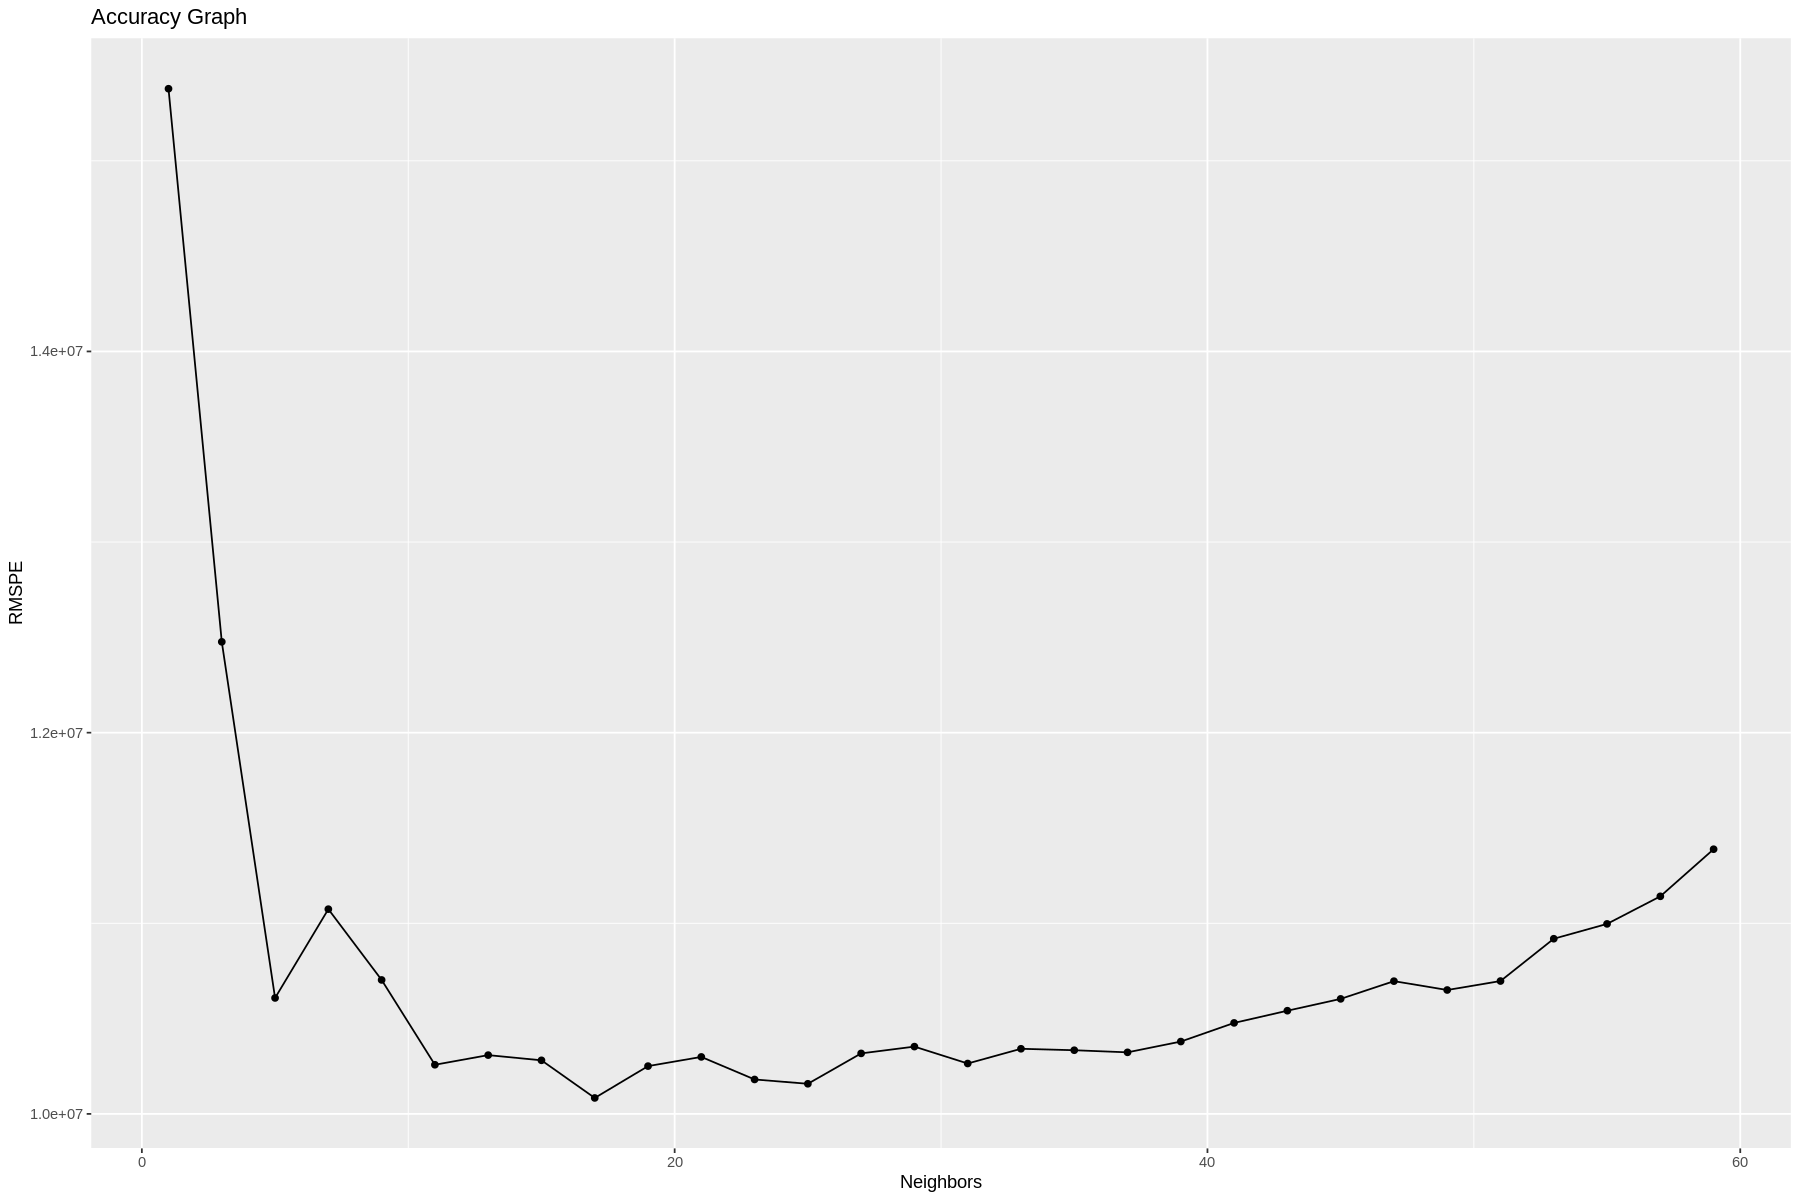

In [10]:
neighbor_pplot <-  ggplot(player_results, aes(x = neighbors, y = mean))+
      geom_point() +
      geom_line() +
      labs(x = "Neighbors", y = "RMSPE")+
        ggtitle("Accuracy Graph")

neighbor_pplot

In [12]:
minimum_error <- player_results %>%
                arrange(mean) %>% 
   slice(1)

minimum_error

k_min <- minimum_error %>%
         pull(neighbors)

player_best_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = k_min) %>%
         set_engine("kknn") %>%
         set_mode("regression")

player_best_fit <- workflow() %>%
         add_recipe(player_recipe) %>%
         add_model(player_best_spec) %>%
         fit(data = player_train)

player_summary <- player_best_fit %>%
          predict(player_test) %>%
          bind_cols(player_test) 
player_metrics <- player_summary%>%
          metrics(truth = Career_earnings, estimate = .pred)

player_summary 
player_metrics

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
17,rmse,standard,10083672,4,6384767,Model09


.pred,Age,Handedness,Best_Rank,Name,Backhand,Height,Seasons_active,Career_earnings
<dbl>,<int>,<fct>,<int>,<chr>,<fct>,<dbl>,<dbl>,<dbl>
6261037,22,Right-handed,3,Alexander Zverev,Two-handed,198,8,20028563
14166908,36,Left-handed,7,Fernando Verdasco,Two-handed,188,19,17353811
6655484,32,Right-handed,25,Jeremy Chardy,Two-handed,188,15,8658443
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
2651444,34,Right-handed,78,Konstantin Kravchuk,Two-handed,190,9,1031708
1555167,30,Right-handed,98,Andrej Martin,Two-handed,180,7,898701
1591829,31,Right-handed,112,Attila Balazs,Two-handed,180,8,450046


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,3.378084e+06
rsq,standard,4.791937e-01
mae,standard,2.012448e+06


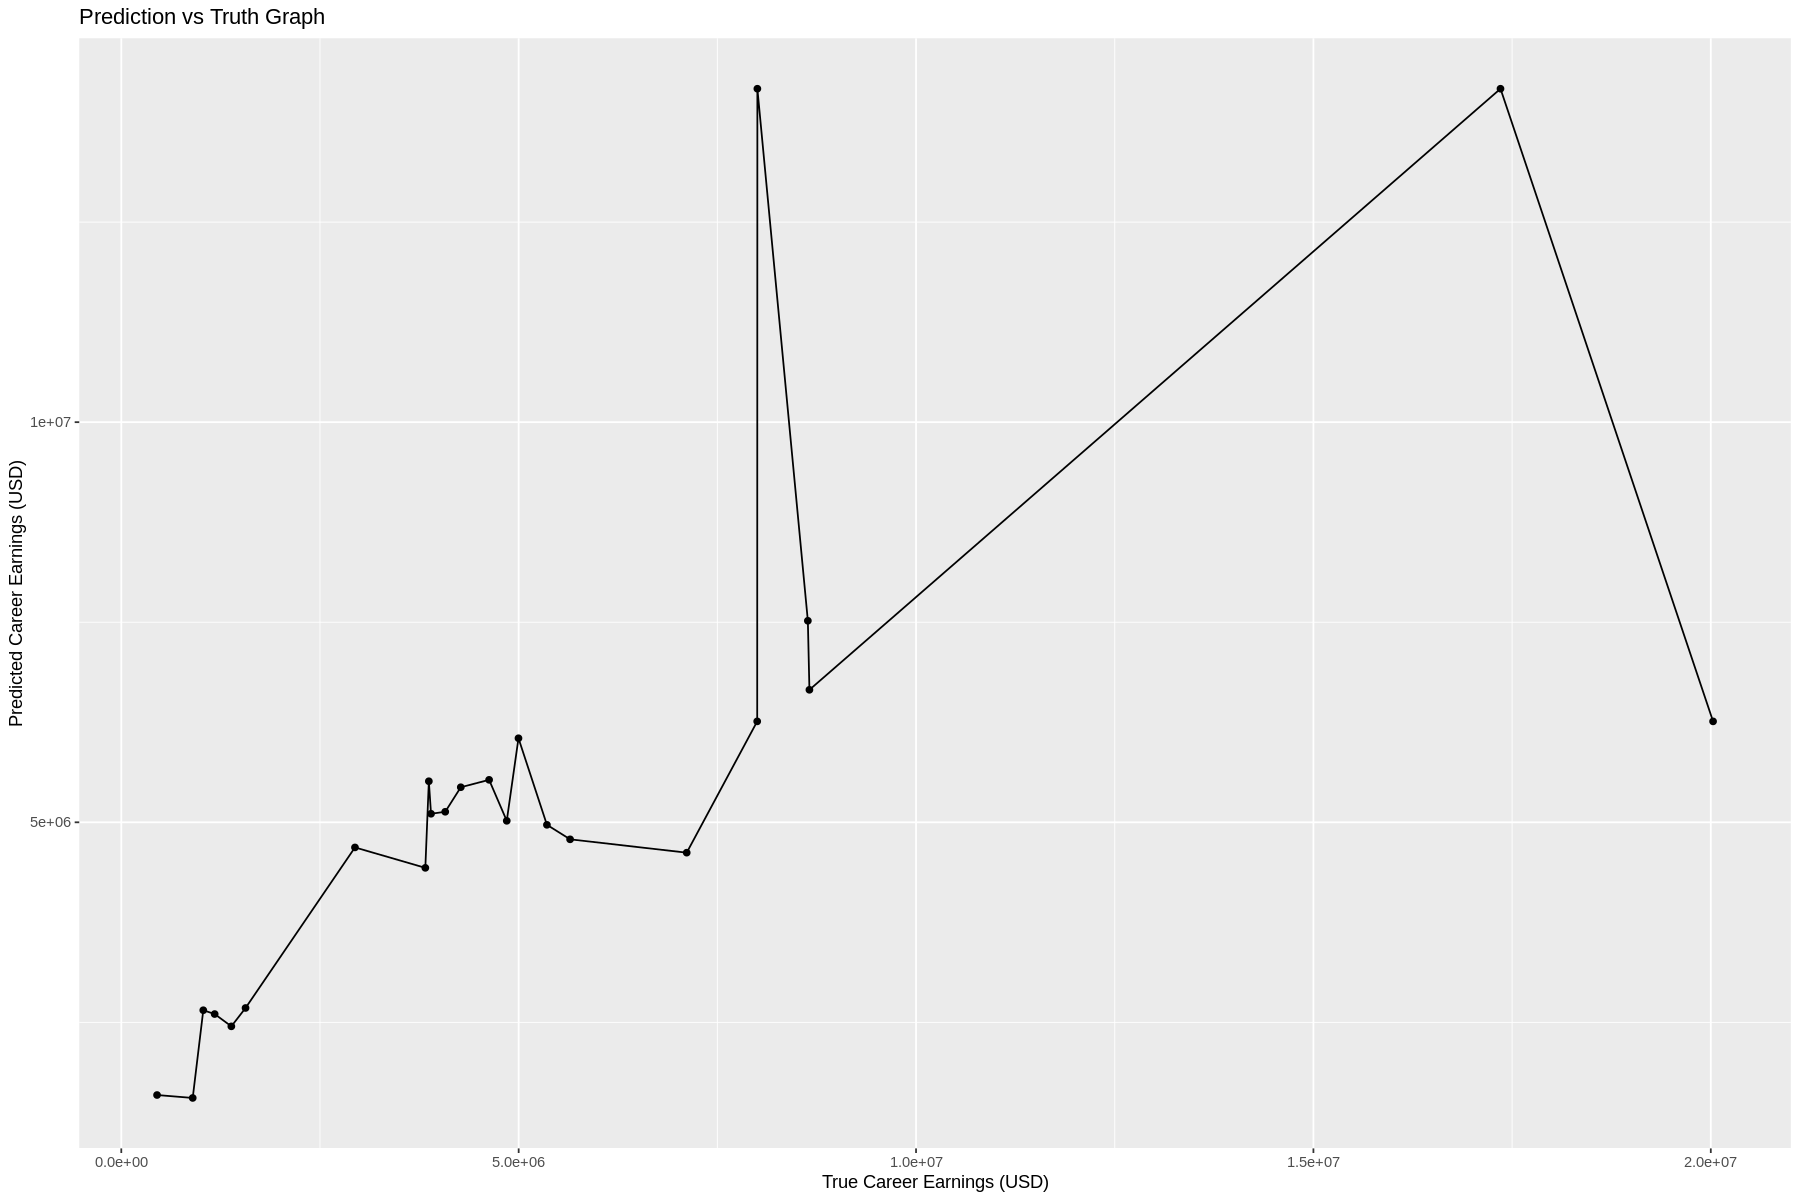

In [13]:
prediction_pplot <-  ggplot(player_summary , aes(x = Career_earnings, y = .pred))+
      geom_point() +
      geom_line() +
      labs(x = "True Career Earnings (USD)", y = "Predicted Career Earnings (USD)")+
        ggtitle("Prediction vs Truth Graph")

prediction_pplot

In [15]:
# create an empty tibble to store the results
accuracies <- tibble(size = integer(), 
                     model_string = character(), 
                     rmse = numeric())

player_spec <- nearest_neighbor(weight_func = "rectangular", 
                              neighbors = tune())%>%
                          set_engine("kknn") %>%
                          set_mode("regression")

names <- colnames(player_train_viz %>% select(-Career_earnings))

# store the total number of predictors
n_total <- length(names)

# stores selected predictors
selected <- c()

# for every size from 1 to the total number of predictors
for (i in 1:n_total) {
    # for every predictor still not added yet
    accs <- list()
    models <- list()
    for (j in 1:length(names)) {
        # create a model string for this combination of predictors
        preds_new <- c(selected, names[[j]])
        model_string <- paste("Career_earnings", "~", paste(preds_new, collapse="+"))

        # create a recipe from the model string
        player_recipe <- recipe(as.formula(model_string), 
                                data = player_train_viz) %>%
                          step_scale(all_predictors()) %>%
                          step_center(all_predictors())

        # tune the KNN regression model with these predictors, 
        # and collect the accuracy for the best K
        acc <- workflow() %>%
          add_recipe(player_recipe) %>%
          add_model(player_spec) %>%
          tune_grid(resamples = player_vfold, grid = 5) %>%
          collect_metrics() %>%
          filter(.metric == "rmse") %>%
          summarize(mx = min(mean))
        
        acc <- acc$mx %>% unlist()

        # add this result to the data frame
        accs[[j]] <- acc
        models[[j]] <- model_string
    }
    jstar <- which.max(unlist(accs))
    accuracies <- accuracies %>% 
      add_row(size = i, 
              model_string = models[[jstar]], 
              rmse = accs[[jstar]])
    selected <- c(selected, names[[jstar]])
    names <- names[-jstar]
}
accuracies

size,model_string,rmse
<int>,<chr>,<dbl>
1,Career_earnings ~ Height,10942762
2,Career_earnings ~ Height+Age,11140846
3,Career_earnings ~ Height+Age+Best_Rank,9941620
4,Career_earnings ~ Height+Age+Best_Rank+Seasons_active,9168163


# Discussion